In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import function as func
import csv

import math

outdir = './plot/result_figure/'

# Convert the fit result $P_{\mathrm{DP}}$ to $\chi$ limit

$$
\chi = 1.248 \times 10^{-10} 
\left( 
\frac{P_{\mathrm{DP}}}{10^{-19}\,\mathrm{W}} 
\frac{10\,\mathrm{cm^2}}{A_{\mathrm{eff}}} 
\frac{0.39\,\mathrm{GeV/cm^3}}{\rho} 
\right)^{1/2} 
\frac{\sqrt{2/3}}{\alpha}
$$

係数は小高修論では $1.4\times 10^{-10}$ だったが、これは誤り


In [4]:
check_freq = func.check_freq
check_freq = check_freq*1000 - 250

A_geom = np.pi * (59.3/2*1e-3)**2 # Physical aperture
eta_eff = 0.629 #  Get from Aeff_analysis.ipnb (from HFSS simulation)
sigma_95CL = 1.715 # Get from get_N_eff.ipynb

# Systematics errors
### New 2022.04.12 S.Adachi ###
#'''
# on Aeff [from xy_scan.ipynb]
# max diff on beam width = 0.1385
# max diff on Aeff = 0.2859
# std diff on beam width = 0.04222
# std diff on Aeff = 0.0843
Aeff_errratio = 0.0843

gaindiff_errratio = 0.06835459615129354 # on P_DP [from yfactor_plot_all.ipynb]
gainTemp_errratio = (2+1)/(300-77) # on P_DP [2K error on 300K and 1K error on 77K]
gainEccosorb_errratio = 0.01*1e-2 # 0.01% reflectivity
gain_eta_win_errratio = 0.0386 # on eta_win --> P_DP [from xy_scan.ipynb]
alignment_theta_err_deg = 0.05 # deg (angle meter accuracy)
conversion_theta_err_deg = 0.06 # deg (from theory)
sigma_deg_265 = 13.95 # sigma1/2(FWHM) deg @ 26.5 GHz [from xy_analysis.ipynb]
rho_errratio = 0.077 # on rho (DM density)
binning_errratio = 1.191657 * 0.01 # [from peak_search.ipynb]
#'''

### Old ###
'''
Aeff_errratio = 0.129 # on Aeff [from xy_scan.ipynb]
gaindiff_errratio = 0.06835459615129354 # on P_DP [from yfactor_plot_all.ipynb]
gainTemp_errratio = (2+1)/(300-77) # on P_DP [2K error on 300K and 1K error on 77K]
gainEccosorb_errratio = 0.01*1e-2 # 0.01% reflectivity
gain_eta_win_errratio = 0.129 # on eta_win --> P_DP [from xy_scan.ipynb]
alignment_theta_err_deg = 0.05 # deg (angle meter accuracy)
conversion_theta_err_deg = 0.06 # deg (from theory)
sigma_deg_265 = 15. # sigma1/2 deg @ 26.5 GHz [from xy_analysis.ipynb]
rho_errratio = 0.077 # on rho (DM density)
'''


# Sum gain errors
gain_errratios = np.array([gaindiff_errratio, gainTemp_errratio, gainEccosorb_errratio, gain_eta_win_errratio])
gainTotal_errratio = np.sqrt( np.sum(np.power(gain_errratios, 2.)) ) # on P_DP
# Calculate angle errors to P_DP errors
# Old version has a mistake by Kotaka
#def get_theta_shift_err(x, sigma): return 1. - np.exp( -x/(sigma/2.))
def get_theta_shift_err(x, sigma): return 1. - np.exp( -x**2./(2.*sigma**2.))
alignment_errratio  = get_theta_shift_err(alignment_theta_err_deg, sigma_deg_265) # on P_DP from alignment of metal plate
conversion_errratio = get_theta_shift_err(conversion_theta_err_deg, sigma_deg_265) # on P_DP from conversion photon direction error

# Sum all errors on P_DP
#errratios = np.array([gainTotal_errratio, Aeff_errratio, alignment_errratio, conversion_errratio, rho_errratio])
errratios = np.array([gainTotal_errratio, Aeff_errratio, alignment_errratio, conversion_errratio, rho_errratio, binning_errratio])
power_syst_total = np.sqrt( np.sum(np.power(errratios, 2.))  )

chi_syst_total = power_syst_total/2. # This 1/2 comes from sqrt(P_DP), sqrt(1/Aeff), sqrt(1/rho)
print(chi_syst_total)
#chi_syst_total = 0.103 #  Error on chi (old value)

# Chi syst on 1sigma --> 95 % C.L.
from scipy import stats
# y=ppf(x) は -inf. ~ y  までの正規分布の積分が 100*x % になるような y を返す
# ほしいのは -inf -- +sigma_95 で 95% になる領域で片側で考える
sigma_95 = stats.norm.ppf(0.95) 
chi_syst_total_95CL = chi_syst_total * sigma_95

print('Errors on P_DP')
print(f'  from gain      = {gainTotal_errratio*100:.3f} %')
print(f'      from calib. diff = {gaindiff_errratio*100:.3f} %')
print(f'      from eta_win     = {gain_eta_win_errratio*100:.3f} %')
print(f'      from temperature = {gainTemp_errratio*100:.3f} %')
print(f'      from Eccosorb    = {gainEccosorb_errratio*100:.3f} %')
print(f'  from Aeff      = {Aeff_errratio*100:.3f} %')
print(f'  from alignment = {alignment_errratio*100:.4f} %')
print(f'  from conversion= {conversion_errratio*100:.4f} %')
print(f'  from rho       = {rho_errratio*100:.3f} %')
print(f'  from binning   = {binning_errratio*100:.3f} %')
print(f'Total error on P_DP = {power_syst_total*100:.3f} %')

print()
print('Errors on \chi')
print(f'  from gain      = {gainTotal_errratio/2.*100:.3f} %')
print(f'      from calib. diff = {gaindiff_errratio/2.*100:.3f} %')
print(f'      from eta_win     = {gain_eta_win_errratio/2.*100:.3f} %')
print(f'      from temperature = {gainTemp_errratio/2.*100:.3f} %')
print(f'      from Eccosorb    = {gainEccosorb_errratio/2.*100:.3f} %')
print(f'  from Aeff      = {Aeff_errratio/2.*100:.3f} %')
print(f'  from alignment = {alignment_errratio/2.*100:.4f} %')
print(f'  from conversion= {conversion_errratio/2.*100:.4f} %')
print(f'  from rho       = {rho_errratio/2.*100:.3f} %')
print(f'  from binning   = {binning_errratio/2.*100:.3f} %')
print(f'Total error on chi (1sigma)  = {chi_syst_total*100:.3f} %')
print(f'Total error on chi (95% C.L.)  = {chi_syst_total_95CL*100:.3f} %')

# Function of eta_window
# Obtained from Aeff_analysis.ipynb
# function(nu) = a(nu[GHz]-22 GHz) + b
# a = 0.017279 +/- 0.00018
# b = 0.238357 +/- 0.000465
def eta_win(freq, a=0.017279, b=0.238357):
    return a * (freq - 22.) + b

val_max = 0.
val_min = 1.

0.06985842200292147
Errors on P_DP
  from gain      = 7.964 %
      from calib. diff = 6.835 %
      from eta_win     = 3.860 %
      from temperature = 1.345 %
      from Eccosorb    = 0.010 %
  from Aeff      = 8.430 %
  from alignment = 0.0006 %
  from conversion= 0.0009 %
  from rho       = 7.700 %
  from binning   = 1.192 %
Total error on P_DP = 13.972 %

Errors on \chi
  from gain      = 3.982 %
      from calib. diff = 3.418 %
      from eta_win     = 1.930 %
      from temperature = 0.673 %
      from Eccosorb    = 0.005 %
  from Aeff      = 4.215 %
  from alignment = 0.0003 %
  from conversion= 0.0005 %
  from rho       = 3.850 %
  from binning   = 0.596 %
Total error on chi (1sigma)  = 6.986 %
Total error on chi (95% C.L.)  = 11.491 %


## Calculate $\chi$ limit with a wrong calculation in max(P, 0)

freq = 18.0 GHz
freq = 19.0 GHz
freq = 20.0 GHz
freq = 21.0 GHz
freq = 22.0 GHz
freq = 23.0 GHz
freq = 24.0 GHz
freq = 25.0 GHz
freq = 26.0 GHz
8.079389588182873e-11
2.263701350379477e-11


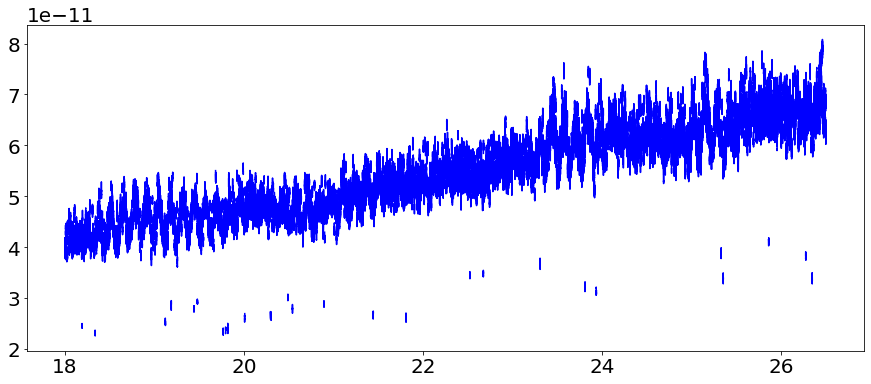

In [5]:
out_path = "/data/ms2840a/result_data/chi_limit_final2.csv"

plt.figure(figsize=(15,6))
plt.rcParams["font.size"] = 20
#fig.suptitle("Result of Exp.1 ~ Exp.4")

chi_max = 0
chi_min = 1.

# Write limit in csv file
with open(out_path, "w") as f:
    writer = csv.writer(f)
    writer.writerow(["freq", "chi"])

    #for i in range(180, 265, 1):
    for i in range(180, 265, 1):
        if i%10 == 0: print(f'freq = {i*0.1} GHz')
        start_freq = i/10
        initial = int(start_freq * 1.e+6 - 250)
        final = int(initial + 1.e+5)
        for j in range(initial, final, 2000):
            word = list(str(j))
            word.insert(2, ".")
            start = "".join(word)
            val = [] # array of P_DP limit
            if float(start)*1e6 in check_freq:
                path = "/data/ms2840a/result_data/check_result/fit_result/start_{}GHz.csv".format(start)
                data = func.csv_to_array(path)
                # WRONG!!
                val = np.max(data["P"],0) + sigma_95CL*data["P_err"]
            else:
                path = "/data/ms2840a/result_data/fit_result/start_{}GHz.csv".format(start)
                data = func.csv_to_array(path)
                # WRONG!!
                val = np.max(data["P"],0) + sigma_95CL*data["P_err"]
                pass
                         
            # Upper limit on P_DP (val) --> Upper limit on Chi + syst. uncertaintis (1.103) 
            #chi = (1.+chi_syst_total) * 1.4e-10 * (val * eta_win(data["freq_0"]/1e9) / 1e-19)**0.5 * (1e-3 / (A_geom*eta_eff))**0.5
            chi = (1.+chi_syst_total_95CL) * 1.248e-10 * (val * eta_win(data["freq_0"]/1e9) / 1e-19)**0.5 * (1e-3 / (A_geom*eta_eff))**0.5
            plt.plot(data["freq_0"]/1e9, chi, color="blue")
            chi_max = max(chi_max, np.max(chi))
            chi_min = min(chi_min, np.min(chi))
            
            for freq, chi in zip(data['freq_0'], chi):
                writer.writerow([freq*1e-9, chi])
                pass
            pass
        pass
    pass

print(chi_max)
print(chi_min)

## Calculate $\chi$ limit (Correct calculation & new rebinning)

freq = 18.0 GHz
freq = 19.0 GHz
freq = 20.0 GHz
freq = 21.0 GHz
freq = 22.0 GHz
freq = 23.0 GHz
freq = 24.0 GHz
freq = 25.0 GHz
freq = 26.0 GHz
2.028088204260824e-10
3.3151632600695674e-11


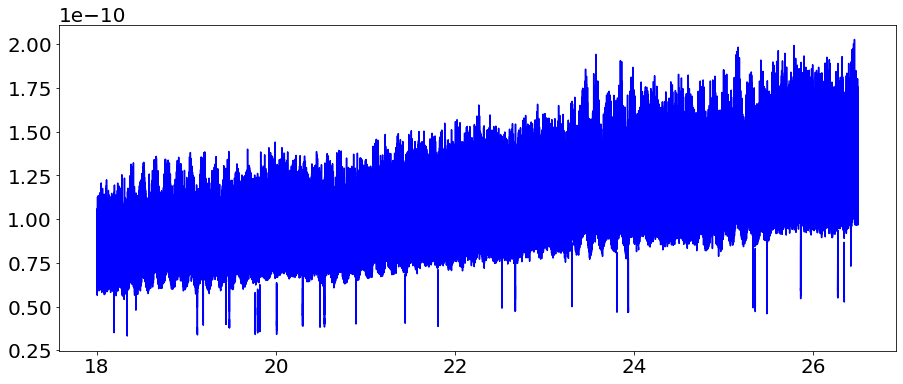

In [6]:
'''
# Old fit
out_path = "/data/ms2840a/result_data/chi_limit_final3.csv"
indir_check = "/data/ms2840a/result_data/check_result/fit_result"
indir       = "/data/ms2840a/result_data/fit_result"
'''

'''
# New fit with new rebinning method
out_path = "/data/ms2840a/result_data/chi_limit_final3_newrebin.csv"
indir_check = "./output/result_data/fit_result_newrebin/"
indir       = "./output/result_data/fit_result_newrebin/"
'''

'''
# New fit with new rebinning method (rebinmethod=0)
out_path = "/data/ms2840a/result_data/chi_limit_final4_newrebin.csv"
indir_check = "./output/result_data_newrebin/fit_result/"
indir       = "./output/result_data_newrebin/fit_result/"
#'''

# New fit with new rebinning method (rebinmethod=1)
'''
out_path = "/data/ms2840a/result_data/chi_limit_final4_newrebin1.csv"
#indir_check = "./output/result_data_newrebin1/fit_result3/"
indir_check = "./output/result_data_newrebin1/fit_result3/after_add"
indir       = "./output/result_data_newrebin1/fit_result3/"
#'''

# New fit with new rebinning method (rebinmethod=1)
'''
out_path = "/data/ms2840a/result_data/chi_limit_final5_newrebin1.csv"
indir_check = "./output/result_data_newrebin1/fit_result4/after_add"
indir       = "./output/result_data_newrebin1/fit_result4/"
#'''

# New fit with newrebin2 (rebinmethod=1, rebin after get_original_signal)
#'''
out_path = "/data/ms2840a/result_data/chi_limit_final_newrebin2.csv"
indir_check = "./output/result_data_newrebin2/fit_result/after_add"
indir       = "./output/result_data_newrebin2/fit_result/"
#'''


freqGHz_min = 18. # GHz
freqGHz_max = 26.5 # GHz
#freqGHz_max = 19 # GHz

plt.figure(figsize=(15,6))
plt.rcParams["font.size"] = 20
#fig.suptitle("Result of Exp.1 ~ Exp.4")

chi_max = 0
chi_min = 1.

freq_limit = []
PDP_limit = []

# Write limit in csv file
with open(out_path, "w") as f:
    writer = csv.writer(f)
    writer.writerow(["freq", "chi"])

    for i in range((int)(freqGHz_min*10), (int)(freqGHz_max*10), 1):
        if i%10 == 0: print(f'freq = {i*0.1} GHz')
        start_freq = i/10
        initial = int(start_freq * 1.e+6 - 250)
        final = int(initial + 1.e+5)
        for j in range(initial, final, 2000):
            word = list(str(j))
            word.insert(2, ".")
            start = "".join(word)
            val = [] # array of P_DP limit
            if float(start)*1e6 in check_freq:
                #path = "/data/ms2840a/result_data/check_result/fit_result/start_{}GHz.csv".format(start)
                path = f"{indir_check}/start_{start}GHz.csv"
                data = func.csv_to_array(path)
                #val = np.max(data["P"],0) + sigma_95CL*data["P_err"]
                zero = np.full(len(data['P']), 0)
                val = np.max([data["P"],zero], axis=0) + sigma_95CL*data["P_err"]
            else:
                path = f"{indir}/start_{start}GHz.csv"
                data = func.csv_to_array(path)
                zero = np.full(len(data['P']), 0)
                val = np.max([data["P"],zero], axis=0) + sigma_95CL*data["P_err"]
                pass
            # Check fit result
            n_nan = np.sum(np.isnan(data['P_err']))
            if n_nan > 0:
                print(f'WARNING! There are Nan values ({n_nan} fits) in P_err! start+freq = {start} GHz')
                pass
            n_fail = np.sum(~data['success'])
            if n_fail > 0:
                print(f'WARNING! There is failed fits ({n_fail} fits)! start+freq = {start} GHz')
                pass
                         
            # Upper limit on P_DP (val) --> Upper limit on Chi + syst. uncertaintis (1.103) 
            #chi = (1.+chi_syst_total) * 1.4e-10 * (val * eta_win(data["freq_0"]/1e9) / 1e-19)**0.5 * (1e-3 / (A_geom*eta_eff))**0.5
            chi = (1.+chi_syst_total_95CL) * 1.248e-10 * (val * eta_win(data["freq_0"]/1e9) / 1e-19)**0.5 * (1e-3 / (A_geom*eta_eff))**0.5
            plt.plot(data["freq_0"]/1e9, chi, color="blue")
            chi_max = max(chi_max, np.max(chi))
            chi_min = min(chi_min, np.min(chi))
            
            freq_limit += data['freq_0'].tolist()
            PDP_limit += val.tolist()
            for freq, chi in zip(data['freq_0'], chi):
                writer.writerow([freq*1e-9, chi])
                pass
            pass
        pass
    pass

print(chi_max)
print(chi_min)

freq_limit = np.array(freq_limit)
PDP_limit = np.array(PDP_limit)

Text(0.5, 0, 'Frequency [GHz]')

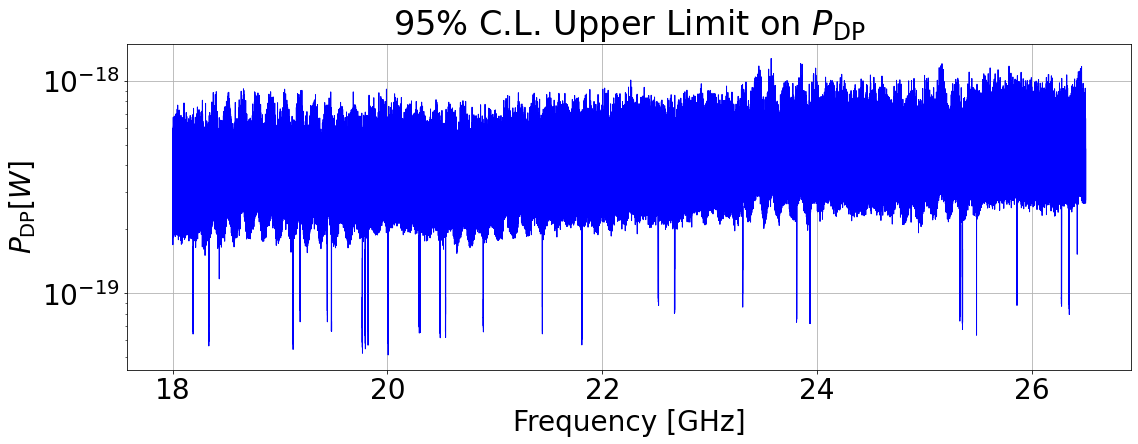

In [7]:
# P_DP limit
plt.figure(figsize=(18,6))
plt.rcParams["font.size"] = 28
plt.plot(freq_limit*1e-9, PDP_limit, color="blue", ls='-', lw=1, marker='o', markersize=0)
plt.grid()
plt.yscale("log")
plt.title(r"95% C.L. Upper Limit on $P_\mathrm{DP}$")
plt.ylabel(r"$P_\mathrm{DP} [W]$")
plt.xlabel("Frequency [GHz]")

#plt.savefig(f"{outdir}/limit_PDP.png")

{'freq': array([18.      , 18.000002, 18.000004, ..., 26.499994, 26.499996,
       26.499998]), 'chi': array([6.25869810e-11, 6.23629846e-11, 6.24729812e-11, ...,
       1.27086102e-10, 1.28280902e-10, 1.29606288e-10])}


(1e-11, 1e-09)

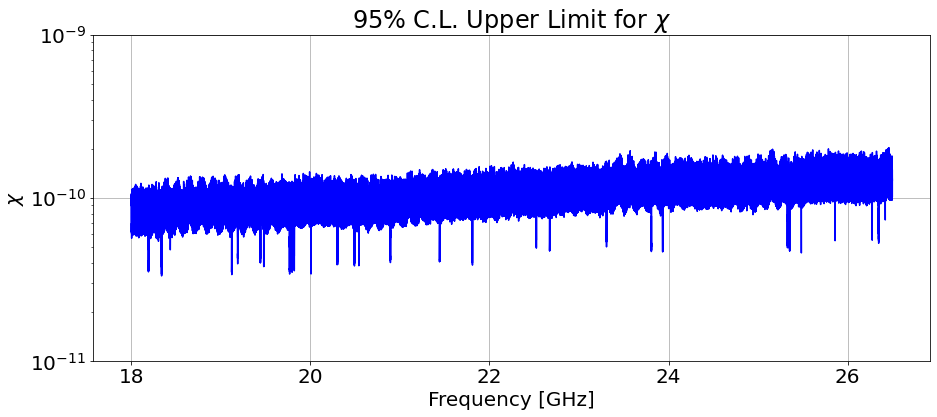

In [10]:
# Check the output chi file
data = func.csv_to_array(out_path)
print(data)

plt.figure(figsize=(15,6))
plt.rcParams["font.size"] = 20
plt.plot(data["freq"], data["chi"], color="blue")
plt.grid()
plt.yscale("log")
plt.title(r"95% C.L. Upper Limit for $\chi$")
plt.ylabel(r"$\chi$")
plt.xlabel("Frequency [GHz]")
plt.ylim([1e-11, 1e-9])

#plt.savefig(f"{outdir}/limit_chi.pdf")

## Limit comparison

In [11]:
# Old fit
data0 = func.csv_to_array("/data/ms2840a/result_data/chi_limit_final2.csv")
label0 = 'Old'
# Bug-1 (max bug) fixed fit
data1 = func.csv_to_array("/data/ms2840a/result_data/chi_limit_final3.csv")
label1 = 'Bug-1 fixed'
# New fit with new rebinning method
data2 = func.csv_to_array("/data/ms2840a/result_data/chi_limit_final3_newrebin.csv")
label2 = 'Bug-1&2 fixed'
# New fit with new rebined data (rebinmethod=1)
data3 = func.csv_to_array("/data/ms2840a/result_data/chi_limit_final5_newrebin1.csv")
label3 = 'Bug-1&2 fixed (rebin in all raw data)'
# New fit with new rebined data (rebinmethod=1)
#data4 = func.csv_to_array("/data/ms2840a/result_data/chi_limit_final4_newrebin1.csv")
#label4 = 'Bug-1&2 fixed (rebinned data1)'
# New fit with new rebined data (rebinmethod=1)
#data4 = func.csv_to_array("/data/ms2840a/result_data/chi_limit_final5_newrebin1.csv")
#label4 = 'Bug-1&2 fixed (rebinned data1)'
# New fit with newrebin2 (rebinmethod=1, rebin after get_original_signal)
data4 = func.csv_to_array("/data/ms2840a/result_data/chi_limit_final_newrebin2.csv")
label4 = 'Bug-1&2 fixed (rebin in $P_{in}$)'

/home/dosue/venv/env1/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


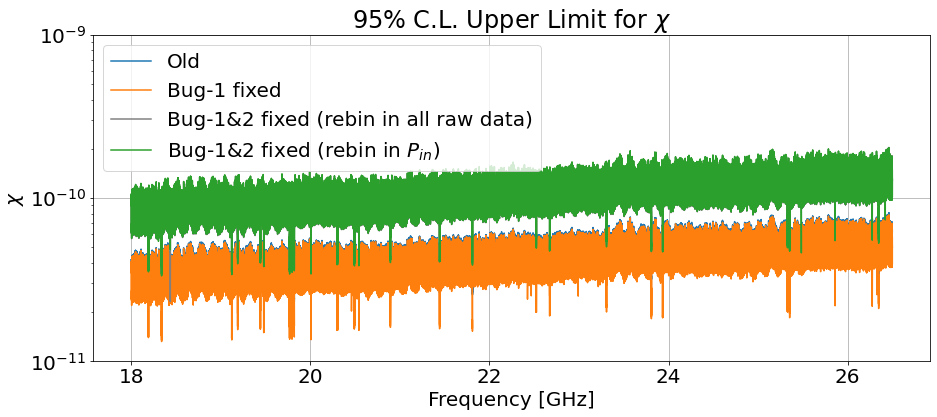

In [12]:
plt.figure(figsize=(15,6))
plt.rcParams["font.size"] = 20

plt.plot(data0["freq"], data0["chi"], color="tab:blue", label=label0)
plt.plot(data1["freq"], data1["chi"], color="tab:orange", label=label1)
#plt.plot(data2["freq"], data2["chi"], color="black", label=label2)
plt.plot(data3["freq"], data3["chi"], color="gray", label=label3)
plt.plot(data4["freq"], data4["chi"], color="tab:green", label=label4)

plt.grid()
plt.yscale("log")
plt.title(r"95% C.L. Upper Limit for $\chi$")
plt.ylabel(r"$\chi$")
plt.xlabel("Frequency [GHz]")
plt.ylim([1e-11, 1e-9])
plt.legend()

/home/dosue/venv/env1/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


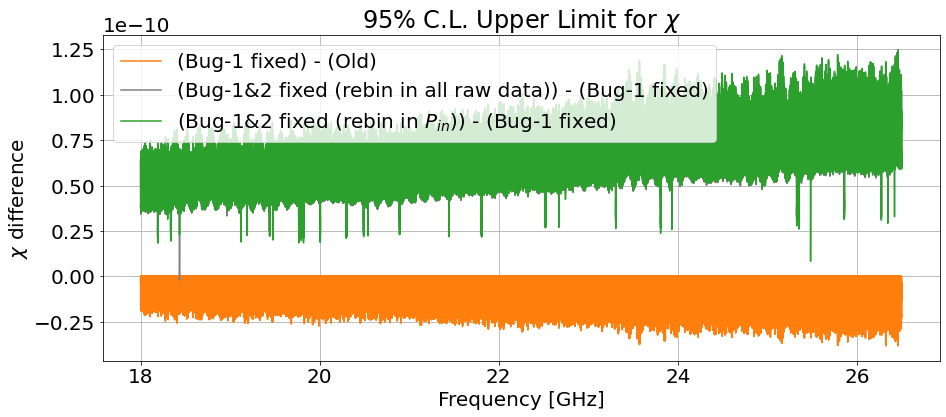

In [13]:
plt.figure(figsize=(15,6))
plt.rcParams["font.size"] = 20

plt.plot(data0["freq"], data1["chi"]-data0['chi'], color="tab:orange", label=f'({label1}) - ({label0})')
#plt.plot(data2["freq"], data2["chi"]-data1["chi"], color="black", label=f'({label2}) - ({label1})')
plt.plot(data3["freq"], data3["chi"]-data1["chi"], color="gray", label=f'({label3}) - ({label1})')
plt.plot(data4["freq"], data4["chi"]-data1["chi"], color="tab:green", label=f'({label4}) - ({label1})')

plt.grid()
plt.title(r"95% C.L. Upper Limit for $\chi$")
plt.ylabel(r"$\chi$ difference")
plt.xlabel("Frequency [GHz]")
plt.legend()

/home/dosue/venv/env1/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


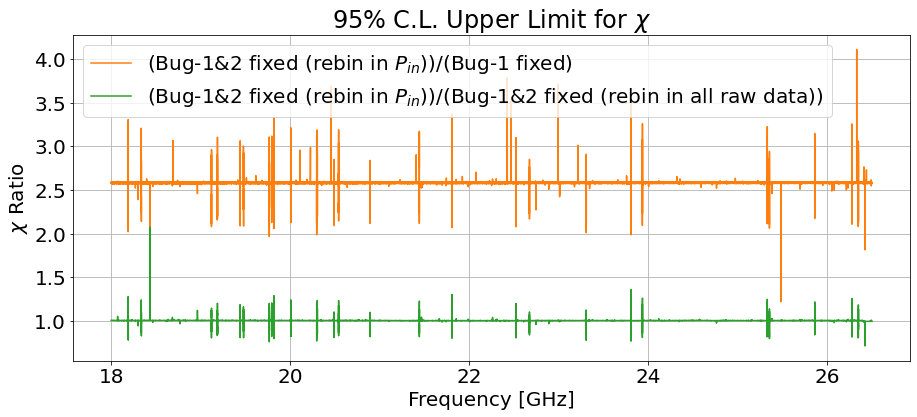

In [14]:
plt.figure(figsize=(15,6))
plt.rcParams["font.size"] = 20

#plt.plot(data0["freq"], data1["chi"]/data0['chi'], color="tab:orange", label=f'({label1})/({label0})')
#plt.plot(data2["freq"], data2["chi"]/data1["chi"], color="black", label=f'({label2})/({label1})')
#plt.plot(data3["freq"], data3["chi"]/data1["chi"], color="gray", label=f'({label3})/({label1})')
#plt.plot(data4["freq"], data4["chi"]/data1["chi"], color="tab:green", label=f'({label4})/({label1})')

plt.plot(data4["freq"], data4["chi"]/data1["chi"], color="tab:orange", label=f'({label4})/({label1})')
plt.plot(data4["freq"], data4["chi"]/data3["chi"], color="tab:green", label=f'({label4})/({label3})')

plt.grid()
plt.title(r"95% C.L. Upper Limit for $\chi$")
plt.ylabel(r"$\chi$ Ratio")
plt.xlabel("Frequency [GHz]")
plt.legend()

# Plot p-local

In [15]:
def getPlocal(
    indir = './output/result_data_newrebin1/signal_p_local',
    indir_add_data = './output/result_data_newrebin1/signal_p_local/before_add',
    f_min = 18.,
    f_max = 26.5,
    is_after = True,
    doPlot = True,
    verbose=0
    ):
    
    min_Hz = int(f_min*1e+9)
    max_Hz = int(f_max*1e+9)
    x = []
    y = []
    
    # 100 MHz span
    for i in range( min_Hz, max_Hz, int(100e+6) ):
        if i%1e+9 == 0: print(f'freq = {i*1e-9} GHz')
        start_GHz = (float)(i*1.0e-9) # GHz
        initial_Hz = i # Hz
        final_Hz = int(initial_Hz + 100e+6) # Hz
        # 2 MHz span
        for j in range( initial_Hz, final_Hz, int(2e+6) ):
            start_str, start_100MHz_str, is_add_data\
                = func.get_file_freq(j, verbose=0)
            if verbose > 0: print(f'file freq string = {start_str}')
            
            # Select input file
            path = f'{indir}/start_{start_str}GHz.csv'
            if is_add_data and (not is_after):
                path = f'{indir_add_data}/start_{start_str}GHz.csv'
                pass
            
            data = func.csv_to_array(path)
            x += data['freq_0'].tolist()
            y += data['p_local'].tolist()
            pass
        pass
    x = np.array(x)
    y = np.array(y)
    
    if doPlot:
        fig, axs = plt.subplots(1,1,figsize=(18,6), squeeze=False, sharex=True)
        ax = axs[0][0]
        #ax.plot(x*1e-9, y, marker='o', markersize=1.0, color='tab:blue', linestyle='')
        ax.plot(x*1e-9, y, marker='', markersize=0.0, color='k', linestyle='-')
        ax.set_xlabel('Frequency [GHz]')
        ax.set_ylabel('$p$-local')
        ax.grid()
        ax.set_yscale('log')
        ax.set_yticks([1e-7,1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.])
        pass
    
    return x, y

### Plot p-local after adding data

freq = 18.0 GHz
freq = 19.0 GHz
freq = 20.0 GHz
freq = 21.0 GHz
freq = 22.0 GHz
freq = 23.0 GHz
freq = 24.0 GHz
freq = 25.0 GHz
freq = 26.0 GHz


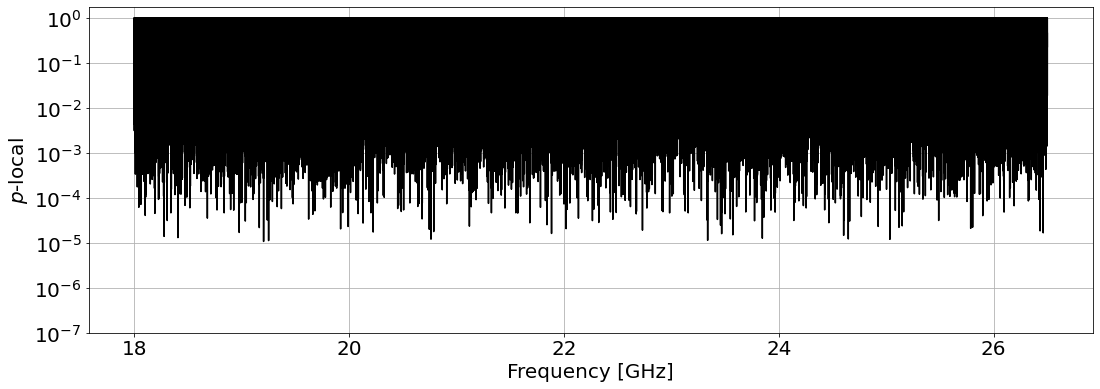

In [16]:
freq, plocal = getPlocal(
    #indir = './output/result_data_newrebin1/signal_p_local4',
    #indir_add_data = './output/result_data_newrebin1/signal_p_local4/after_add',
    indir = './output/result_data_newrebin2/signal_p_local',
    indir_add_data = './output/result_data_newrebin2/signal_p_local/after_add',
    #is_after = True, doPlot = True,
    is_after = False, doPlot = True,
)

In [17]:
zero_freq = freq[np.where( plocal == 0.)]
print(zero_freq)

[]


### Plot p-local before adding data

freq = 18.0 GHz
freq = 19.0 GHz
freq = 20.0 GHz
freq = 21.0 GHz
freq = 22.0 GHz
freq = 23.0 GHz
freq = 24.0 GHz
freq = 25.0 GHz
freq = 26.0 GHz


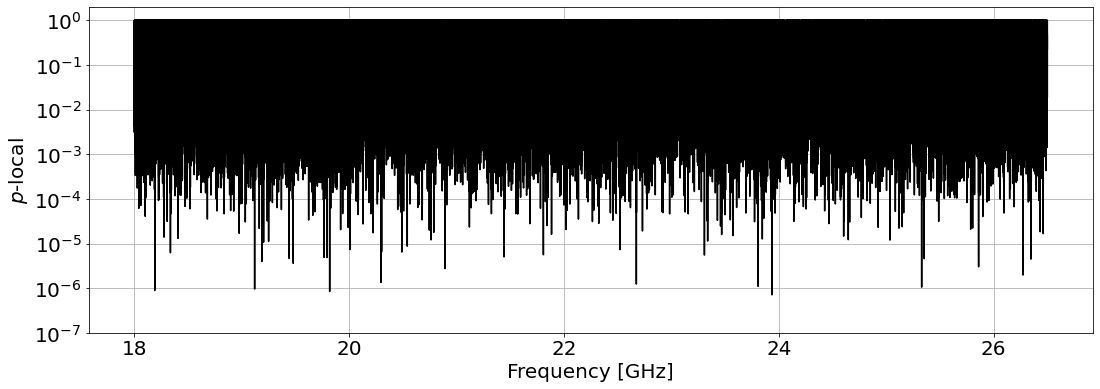

In [18]:
freq_before, plocal_before = getPlocal(
    #indir = './output/result_data_newrebin1/signal_p_local4',
    #indir_add_data = './output/result_data_newrebin1/signal_p_local4',
    indir = './output/result_data_newrebin2/signal_p_local',
    indir_add_data = './output/result_data_newrebin2/signal_p_local',
    is_after = False, doPlot = True,
)

In [19]:
zero_freq_before = freq_before[np.where( plocal_before == 0.)]
print(zero_freq_before)
low_freq_before, low_plocal_before = func.listup_low_plocal(freq_before, plocal_before, lowP=1.0e-5)
func.print_list(low_freq_before, 'low freq')
func.print_list(low_plocal_before, 'low plocal')

[]
18.19081 & 0.92
18.190812 & 0.89
18.190814 & 3.03
18.336724 & 6.21
19.120508 & 6.17
19.12051 & 2.17
19.120512 & 1.12
19.120514 & 0.96
19.187772 & 3.96
19.187774 & 6.71
19.441606 & 4.64
19.479506 & 3.61
19.766974 & 4.91
19.766976 & 8.17
19.794366 & 4.84
19.794368 & 8.18
19.819068 & 7.17
19.81907 & 1.39
19.819072 & 0.84
19.819074 & 3.83
20.00798 & 7.33
20.007982 & 8.26
20.296618 & 5.59
20.29662 & 1.35
20.296622 & 4.53
20.302782 & 8.59
20.302784 & 6.87
20.302786 & 6.57
20.302788 & 6.77
20.490248 & 8.11
20.49025 & 6.44
20.541586 & 8.75
20.89324 & 6.98
20.893242 & 2.74
21.443168 & 5.02
21.808598 & 5.6
22.522232 & 8.37
22.522234 & 7.31
22.673944 & 2.22
22.673946 & 1.24
23.307606 & 5.52
23.80866 & 6.52
23.808662 & 4.49
23.808664 & 1.33
23.808666 & 1.09
23.808668 & 7.55
23.935384 & 4.17
23.935386 & 0.71
25.329952 & 8.02
25.329954 & 3.59
25.329956 & 1.05
25.329958 & 3.1
25.353898 & 4.57
25.86009 & 3.42
25.860092 & 3.0
26.274232 & 2.59
26.274234 & 1.97
26.274236 & 3.04
26.274238 & 4.21
26.347

In [20]:
zero_index_before = np.where( plocal_before == 0.)[0]
zero_freq_before = freq_before[zero_index_before]
zero_plocal_before = plocal_before[zero_index_before]
print(zero_freq_before)

[]


### Plot Kotaka p-local before adding data

freq = 18.0 GHz
freq = 19.0 GHz
freq = 20.0 GHz
freq = 21.0 GHz
freq = 22.0 GHz
freq = 23.0 GHz
freq = 24.0 GHz
freq = 25.0 GHz
freq = 26.0 GHz


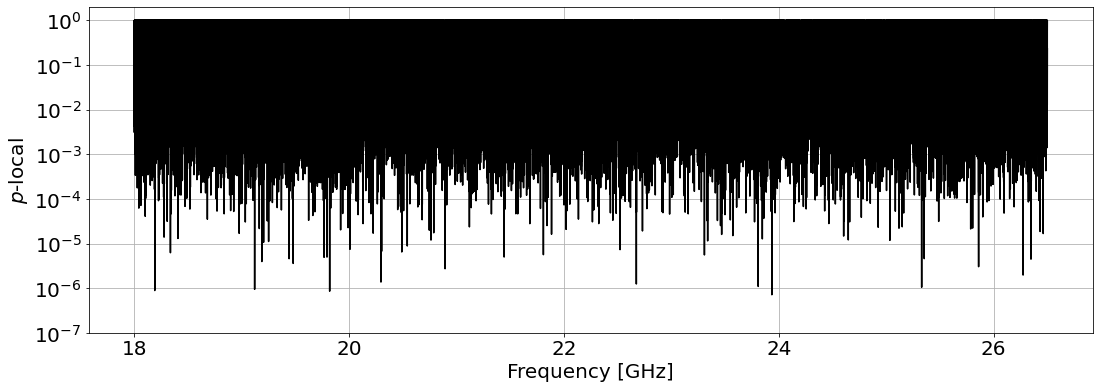

In [21]:
# Old data has p-local before adding in indir --> is_after = True
freq_kotaka, plocal_kotaka = getPlocal(
    indir = '/data/ms2840a/result_data/signal_p_local',
    indir_add_data = '/data/ms2840a/result_data/check_result/signal_p_local_mean_W',
    is_after = True, doPlot = True,
)

In [22]:
zero_freq_kotaka = freq_kotaka[np.where( plocal_kotaka == 0.)]
print(zero_freq_kotaka)
low_freq_kotaka, low_plocal_kotaka = func.listup_low_plocal(freq_kotaka, plocal_kotaka, lowP=1.0e-5)
func.print_list(low_freq_kotaka, 'low freq')
func.print_list(low_plocal_kotaka, 'low plocal')

[]
18.19081 & 0.92
18.190812 & 0.89
18.190814 & 3.01
18.336724 & 6.22
19.120508 & 6.18
19.12051 & 2.15
19.120512 & 1.11
19.120514 & 0.94
19.187772 & 3.95
19.187774 & 6.71
19.441606 & 4.57
19.479506 & 3.58
19.766974 & 4.91
19.766976 & 8.18
19.794366 & 4.97
19.794368 & 8.22
19.819068 & 7.22
19.81907 & 1.38
19.819072 & 0.86
19.819074 & 3.86
20.00798 & 7.42
20.007982 & 8.22
20.296618 & 5.84
20.29662 & 1.37
20.296622 & 4.64
20.302782 & 8.5
20.302784 & 6.88
20.302786 & 6.71
20.302788 & 6.71
20.490248 & 8.15
20.49025 & 6.46
20.541586 & 8.81
20.89324 & 6.76
20.893242 & 2.72
21.443168 & 4.98
21.808598 & 5.62
22.522232 & 8.15
22.522234 & 7.29
22.673944 & 2.26
22.673946 & 1.24
23.307606 & 5.55
23.80866 & 6.5
23.808662 & 4.44
23.808664 & 1.31
23.808666 & 1.09
23.808668 & 7.56
23.935384 & 4.4
23.935386 & 0.71
25.329952 & 8.01
25.329954 & 3.61
25.329956 & 1.05
25.329958 & 3.09
25.353898 & 4.58
25.86009 & 3.43
25.860092 & 3.03
26.274232 & 2.56
26.274234 & 1.97
26.274236 & 3.02
26.274238 & 4.14
26.347

In [23]:
for i,j in zip(low_freq_before, low_freq_kotaka):
    print(i,j, i-j)
    pass

18190812000.0 18190812000.0 0.0
18336724000.0 18336724000.0 0.0
19120514000.0 19120514000.0 0.0
19187772000.0 19187772000.0 0.0
19441606000.0 19441606000.0 0.0
19479506000.0 19479506000.0 0.0
19766974000.0 19766974000.0 0.0
19794366000.0 19794366000.0 0.0
19819072000.0 19819072000.0 0.0
20007980000.0 20007980000.0 0.0
20296620000.0 20296620000.0 0.0
20302786000.0 20302788000.0 -2000.0
20490250000.0 20490250000.0 0.0
20541586000.0 20541586000.0 0.0
20893242000.0 20893242000.0 0.0
21443168000.0 21443168000.0 0.0
21808598000.0 21808598000.0 0.0
22522234000.0 22522234000.0 0.0
22673946000.0 22673946000.0 0.0
23307606000.0 23307606000.0 0.0
23808666000.0 23808666000.0 0.0
23935386000.0 23935386000.0 0.0
25329956000.0 25329956000.0 0.0
25353898000.0 25353898000.0 0.0
25860092000.0 25860092000.0 0.0
26274234000.0 26274234000.0 0.0
26347692000.0 26347692000.0 0.0


### P-local Comparison 

In [24]:
low_freq_before2 = low_freq_before
low_freq_before2 = np.delete(low_freq_before2, 3)
for i,j in zip(low_freq_before2, low_freq_kotaka):
    print(i,j, i-j)
    pass

18190812000.0 18190812000.0 0.0
18336724000.0 18336724000.0 0.0
19120514000.0 19120514000.0 0.0
19441606000.0 19187772000.0 253834000.0
19479506000.0 19441606000.0 37900000.0
19766974000.0 19479506000.0 287468000.0
19794366000.0 19766974000.0 27392000.0
19819072000.0 19794366000.0 24706000.0
20007980000.0 19819072000.0 188908000.0
20296620000.0 20007980000.0 288640000.0
20302786000.0 20296620000.0 6166000.0
20490250000.0 20302788000.0 187462000.0
20541586000.0 20490250000.0 51336000.0
20893242000.0 20541586000.0 351656000.0
21443168000.0 20893242000.0 549926000.0
21808598000.0 21443168000.0 365430000.0
22522234000.0 21808598000.0 713636000.0
22673946000.0 22522234000.0 151712000.0
23307606000.0 22673946000.0 633660000.0
23808666000.0 23307606000.0 501060000.0
23935386000.0 23808666000.0 126720000.0
25329956000.0 23935386000.0 1394570000.0
25353898000.0 25329956000.0 23942000.0
25860092000.0 25353898000.0 506194000.0
26274234000.0 25860092000.0 414142000.0
26347692000.0 26274234000.0 73

In [25]:
## Plot null fit result
import fit_script as fit1
indir_before = './output/result_data_newrebin1/signal_12_data/'
n_data = 12
result_list_list = []
for f, p in zip(zero_freq_before, zero_plocal_before):
    print(f,p)
    start_str, start_100MHz, is_add_data = func.get_file_freq(f)
    # Get P_in
    signal = func.csv_to_array(f'{indir_before}/start_{start_str}GHz.csv')
    print(signal.keys())
    freq = signal['freq']
    keys_W = [ f'W_{i}' for i in range(n_data) ]
    W_array = np.array([ signal[key] for key in keys_W ])
    W = np.average(W_array, axis=0) # mean of (W_0, W_1,... W_{n_data})
    print(freq)
    # No rebin
    # Fit without save
    result_list = fit1.fitting(path='', start=(float)(start_str), start_freq=(float)(start_100MHz), 
                               init_values = [0., np.mean(W), 0.],
                               #init_values = [1., 1., 1.],
                               freq=freq, signal=W, verbose=0)
    result_list_list.append(result_list)
    pass

In [26]:
if len(zero_freq_before) > 0:
    freq0 = int(zero_freq_before[0])
    for result_list in result_list_list:
        for i, freq in enumerate(result_list['freq_0']):
            if freq == freq0:
                print(result_list['freq_0'][i])
                print(result_list['P'][i])
                print(result_list['P_err'][i])
                print(result_list['redchi'][i])
                print(result_list['success'][i])
                pass
            pass
        pass
    pass

In [14]:
def plot_add_spec(ax, num):
    

    check_freq = np.array([18190, 18336, 19120, 19186, 19440, 19478, 19766, 19794, 19818, 20006, 20296, 20302, 20490, 20540, 20892, 21442, 21808, 22522, 22672, 23306, 23808, 23934, 25328, 25352, 25860, 26274, 26346])

    line = np.array([
        18.190812,
        18.336724,
        19.120514,
        19.187772,
        19.441606,
        19.479506,
        19.766974,
        19.794366,
        19.819072,
        20.007980,
        20.296620,
        20.302788,
        20.490250,
        20.541586,
        20.893242,
        21.443168,
        21.808598,
        22.522234,
        22.673946,
        23.307606,
        23.808666,
        23.935386,
        25.329956,
        25.353898,
        25.860092,
        26.274234,
        26.347692])
    
    word = list(str(check_freq[num]*1000 - 250))
    word.insert(2, ".")
    start = "".join(word)

    path = "/data/ms2840a/result_data/check_result/signal_p_local_mean_fit/start_{}GHz.csv".format(start)
    data1 = func.csv_to_array(path)

    ax.plot((data1["freq_0"]/1e+9 - np.floor(line[num]*100)/100)*1e3, data1["p_local"], color="blue")
    ax.axvline(x = (line[num] - np.floor(line[num]*100)/100)*1e3, color="red", linestyle='--')
    ax.grid()
    ax.set_yscale("log")
    ax.set_xlabel("Frequency [MHz + {} GHz]".format(np.floor(line[num]*100)/100))
    ax.set_ylabel(r"$p_{\rm local}$")
    ax.set_ylim([5e-6, 2])
    ax.set_yticks([1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
    
    title = ""
    if num+1 == 1 or num+1 == 11 or num+1 == 21: title = str(num+1) + "st"
    elif num+1 == 2 or num+1 == 12 or num+1 == 22: title = str(num+1) + "nd"
    elif num+1 == 3 or num+1 == 13: title = str(num+1) + "rd"
    else: title = str(num+1) + "th"
    ax.set_title(title + r": $\nu_0 = {} ~\rm GHz$".format(line[num]))

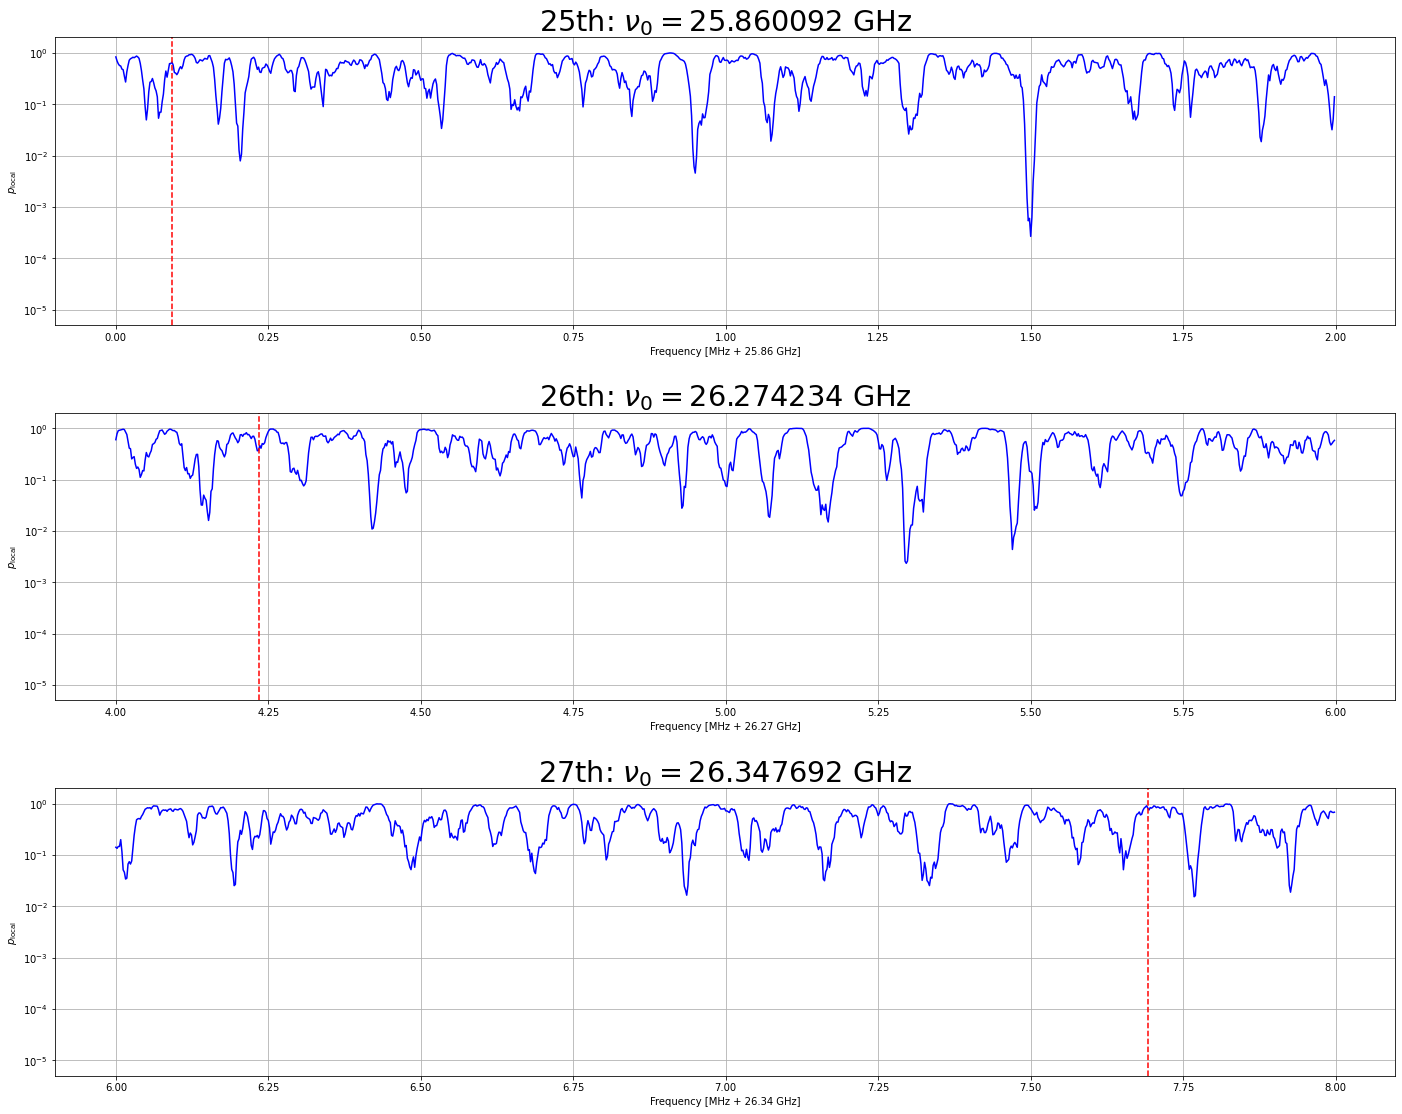

In [15]:
fig, axes = plt.subplots(3,1,figsize=(20,16), squeeze=False)
plt.rcParams["font.size"] = 24

for i in range(3):
    plot_add_spec(axes[i][0], i+24)
                    
fig.tight_layout()

#plt.savefig("../result_figure/under_1e5/from25to27_add.pdf")

# Plot $P_\mathrm{DP}$ & $p$-local

## Get $P_{DP}$ & $p$-local data 

In [27]:
''' Original
datadir = '/data/ms2840a/result_data'
fit_dir = 'fit_result'
fit_dir_after = 'check_result/fit_result_mean_W'
plocal_dir = 'signal_p_local'
plocal_dir_after = 'check_result/signal_p_local_mean_W'
outdir = './plot/result_figure/fit_result'
'''

''' rebin in all raw data (newrebin1/fit_result4)
datadir = './output/result_data_newrebin1/'
fit_dir = 'fit_result4'
fit_dir_after = 'fit_result4/after_add'
plocal_dir = 'signal_p_local4'
plocal_dir_after = 'signal_p_local4/after_add'
outdir = './plot/result_figure_newrebin1/fit_result4'
#'''

#''' rebin in P_in (newrebin2/fit_result)
datadir = './output/result_data_newrebin2/'
fit_dir = 'fit_result'
fit_dir_after = 'fit_result/after_add'
plocal_dir = 'signal_p_local'
plocal_dir_after = 'signal_p_local/after_add'
outdir = './plot/result_figure_newrebin2/fit_result'
#'''


if not os.path.isdir(outdir): os.makedirs(outdir)
    

check_freq = func.check_freq
check_freq = check_freq*1000 - 250

W_conv = 1.e+18 # convert to aW

# _before: only initial data
# _after: initial data + additional data
# _add: only additional data
freq_P_before = []
freq_P_after = []
freq_P_add = []
freq_before = []
freq_after = []
freq_add = []
y_P_after = []
y_P_before = []
y_P_add = []
y_before = []
y_after = []
y_add = []
for i in range(180, 265, 1):
    start_freq = i/10
    initial = int(start_freq * 1.e+6 - 250)
    final = int(initial + 1.e+5)

    for j in range(initial, final, 2000):
        word = list(str(j))
        word.insert(2, ".")
        start = "".join(word)

        if float(start)*1e6 in check_freq:
            # P_DP before
            path = f"{datadir}/{fit_dir}/start_{start}GHz.csv"
            data = func.csv_to_array(path)
            freq_P_before.append(data['freq_0'])
            y_P_before.append(data['P'])
 
            # P_DP after
            path = f"{datadir}/{fit_dir_after}/start_{start}GHz.csv"
            data = func.csv_to_array(path)
            freq_P_after.append(data['freq_0'])
            y_P_after.append(data['P'])
            freq_P_add.append(data['freq_0'])
            y_P_add.append(data['P'])
 
            # p_local before
            path = f"{datadir}/{plocal_dir}/start_{start}GHz.csv"
            data = func.csv_to_array(path)
            freq_before.append(data['freq_0'])
            y_before.append(data['p_local'])
            
            # p_local after
            path = f"{datadir}/{plocal_dir_after}/start_{start}GHz.csv"
            data = func.csv_to_array(path)
            freq_after.append(data['freq_0'])
            y_after.append(data['p_local'])
            freq_add.append(data['freq_0'])
            y_add.append(data['p_local'])
        else:
            # P_DP
            path = f"{datadir}/{fit_dir}/start_{start}GHz.csv"
            data = func.csv_to_array(path)
            freq_P_before.append(data['freq_0'])
            y_P_before.append(data['P'])
            freq_P_after.append(data['freq_0'])
            y_P_after.append(data['P'])

            # p_local
            path = f"{datadir}/{plocal_dir}/start_{start}GHz.csv"
            data = func.csv_to_array(path)
            freq_before.append(data['freq_0'])
            y_before.append(data['p_local'])
            freq_after.append(data['freq_0'])
            y_after.append(data['p_local'])
            pass
        pass

    pass

freq_P_before = np.array(freq_P_before)
freq_P_after = np.array(freq_P_after)
freq_P_add = np.array(freq_P_add)
freq_before = np.array(freq_before)
freq_after = np.array(freq_after)
freq_add = np.array(freq_add)
y_P_before = np.array(y_P_before)
y_P_after = np.array(y_P_after)
y_P_add = np.array(y_P_add)
y_before = np.array(y_before)
y_after = np.array(y_after)
y_add = np.array(y_add)

In [28]:
print(y_before.shape)
print(y_after.shape)
print(y_add.shape)

(4250, 1000)
(4250, 1000)
(27, 1000)


## Plot $P_{DP}$ & $p$-local data  (Original)

In [37]:
def plot_PDP_plocal(showAfter=True):
    fig, axes = plt.subplots(2,1,figsize=(14,10), squeeze=False, sharex=True)
    #before_color='black'
    #after_color='lightcoral'
    #before_color='black'
    #before_color='gray'
    before_color='darkgray'
    #before_color='dimgray'
    #before_color='tab:blue'
    #after_color='red'
    after_color='tab:red'
    #after_color='black'
    #after_color='tab:red'
    #after_color='tab:blue'
    fig.tight_layout()

    #axes[0][0].plot(freq_P_before.ravel()*1.0e-9, y_P_before.ravel()*W_conv, color=before_color, linewidth=2)
    #axes[0][0].plot(freq_P_after.ravel()*1.0e-9, y_P_after.ravel()*W_conv, color=after_color, linewidth=2)
    #axes[1][0].plot(freq_before.ravel()*1.0e-9, y_before.ravel(), color=before_color, linewidth=2)
    #axes[1][0].plot(freq_after.ravel()*1.0e-9, y_after.ravel(), color=after_color, linewidth=2)

    #axes[0][0].plot(freq_P_before.ravel()*1.0e-9, y_P_before.ravel()*W_conv, color=before_color, linestyle='', markersize=2.0, marker='o')
    axes[0][0].plot(freq_P_before.ravel()*1.0e-9, y_P_before.ravel()*W_conv, color=before_color, lw=2)
    if showAfter:
        for _f, _y in zip(freq_P_add, y_P_add):
            #axes[0][0].plot(_f*1.0e-9, _y*W_conv, color=after_color, linestyle='', markersize=2.0, marker='o')
            axes[0][0].plot(_f*1.0e-9, _y*W_conv, color=after_color, lw=2)
            pass
        pass
    #axes[1][0].plot(freq_before.ravel()*1.0e-9, y_before.ravel(), color=before_color, linestyle='', markersize=2.0, marker='o')
    axes[1][0].plot(freq_before.ravel()*1.0e-9, y_before.ravel(), color=before_color, lw=2)
    if showAfter:
        for _f, _y in zip(freq_add, y_add):
            #axes[1][0].plot(_f*1.0e-9, _y, color=after_color, linestyle='', markersize=2.0, marker='o')
            axes[1][0].plot(_f*1.0e-9, _y, color=after_color, lw=2)
            pass
        pass

    plt.rcParams["font.size"] = 28
    plt.rcParams["mathtext.fontset"] = 'stix'
    plt.rcParams["font.family"] = 'serif'

    ax = axes[0][0]
    ax.grid()
    #ax.set_xlim([19.99, 20.01])
    #ax.set_ylim([-0.18, 0.18])
    #ax.set_ylim([-1.1, 1.1])
    ax.set_ylim([-2.1, 2.1])
    ax.set_yticks([-2, -1, 0, 1, 2])
    ax.set_ylabel(r"$P_{\rm DP} ~(\mathrm{aW})$", labelpad=12, fontsize=36)
    ax = axes[1][0]
    ax.grid()
    #ax.set_xlim([19.99, 20.01])
    ax.set_yscale("log")
    ax.set_ylabel(r"$p_{\rm local}$", labelpad=12, fontsize=36)
    ax.set_yticks([1e+2, 1e-0, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10])
    #ax.set_yticks([1e-0, 1e-2, 1e-4, 1e-7])
    ax.set_xlabel("Frequency (GHz)", fontsize=36)
    #ax.set_ylim([5e-7, 2])
    ax.set_ylim([1e-7 , 1e+1])

    fig.subplots_adjust(hspace=0.05, left=0.15, bottom=0.15)
    return fig

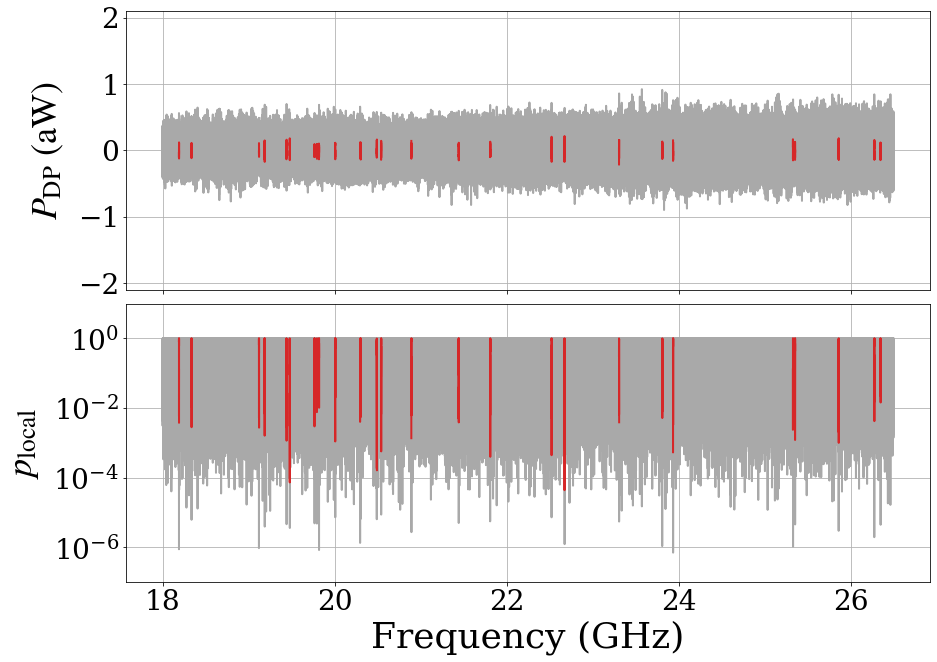

In [38]:
fig = plot_PDP_plocal()

#fig.savefig(f'{outdir}/plocal_after_gray.png')
#fig.savefig(f'{outdir}/plocal_after_{after_color}.png')
#fig.savefig(f'{outdir}/plocal_after_gray.pdf') # --> Too large
#fig.savefig(f'{outdir}/plocal_after_{after_color}_new.png')
#fig.savefig(f'{outdir}/plocal_before_gray_after_red_new.png')
#fig.savefig(f'{outdir}/plocal_before_dimgray_after_red_new.png')
#fig.savefig(f'{outdir}/plocal_before_dimgray_after_black_new.png')
fig.savefig(f'{outdir}/plocal_before_darkgray_after_tabred_new.png')

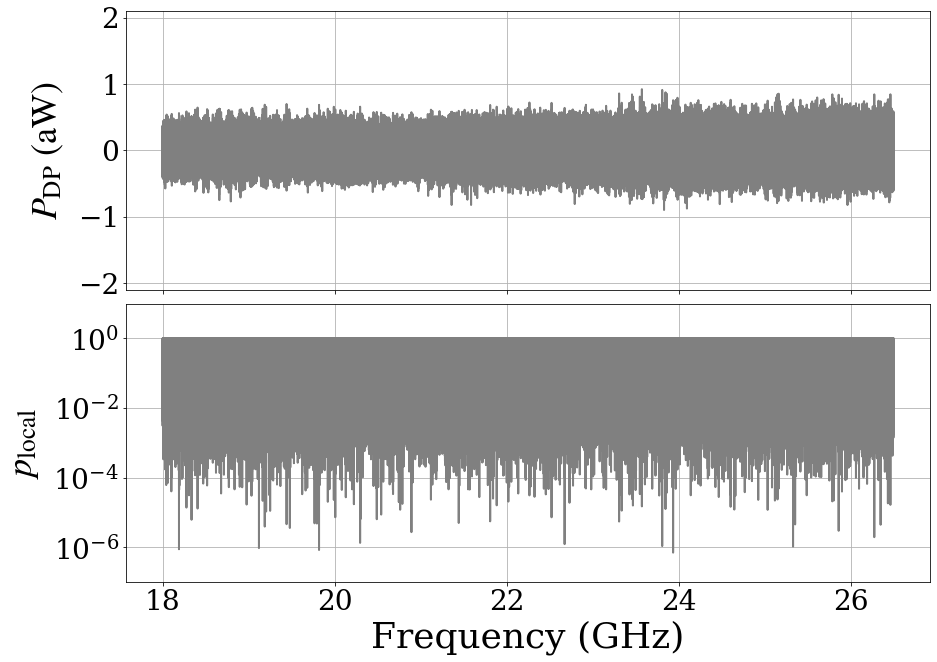

In [43]:
fig = plot_PDP_plocal(showAfter=False)
#fig.savefig(f'{outdir}/plocal_noafter_new.png')

## Plot $P_{DP}$ & $p$-local data with zoom

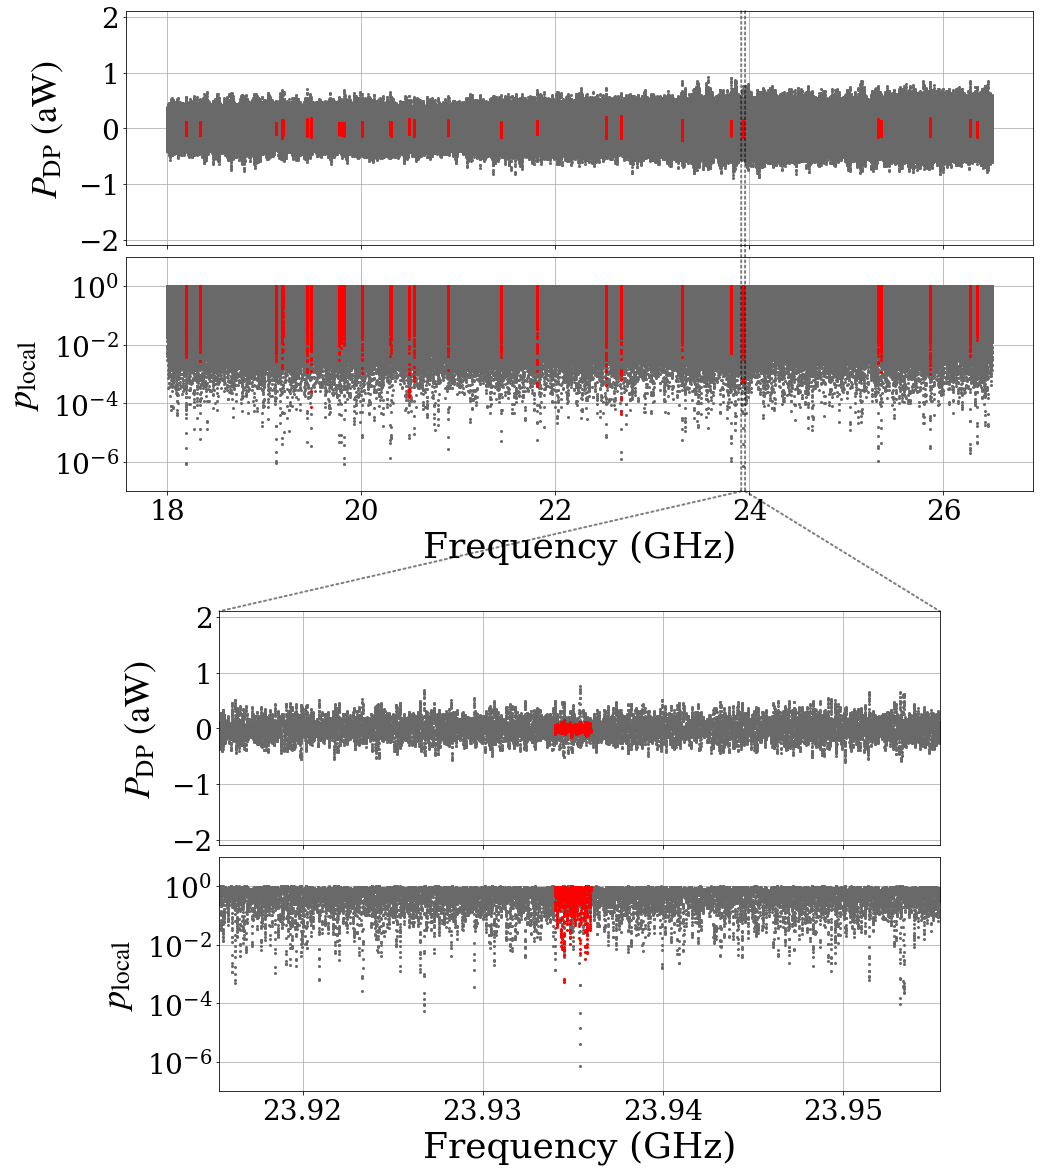

In [155]:
from  matplotlib import gridspec, patches
def plot_PDP_plocal_wt_zoom(showAfter=True):
    fig = plt.figure(figsize=(14, 20))
    # 2 rows
    gscale = 1.
    gs = gridspec.GridSpec(2, 1, figure=fig, 
            height_ratios = [1, gscale], 
            left=0.05, right=0.95, bottom=0.2, top=0.95, 
            wspace=0, hspace=0.25)
    # (2 rows) x 2 rows
    gss = [ gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0], hspace=0.05),
            gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs[1], hspace=0.05, width_ratios=[0.05,0.9,0.05]) ]
    axes =  [ 
        [ plt.subplot(gss[0][j]) for j in range(2) ], 
        [ plt.subplot(gss[1][j, 1]) for j in range(2) ]
    ]
    
    #before_color='black'
    #after_color='lightcoral'
    #before_color='black'
    #before_color='gray'
    #before_color='darkgray'
    before_color='dimgray'
    #before_color='tab:blue'
    after_color='red'
    #after_color='tab:red'
    #after_color='tab:blue'
    
    yticks_pvalue = [1., 1e-2, 1e-4, 1e-6]
    zoom_center = 23.935386
    zoom_dfreq = 0.02
    zoom_xmin = zoom_center - zoom_dfreq
    zoom_xmax = zoom_center + zoom_dfreq
    zoom_xticks  = [23.92, 23.93, 23.94, 23.95]

    axes[0][0].plot(freq_P_before.ravel()*1.0e-9, y_P_before.ravel()*W_conv, color=before_color, linestyle='', markersize=2.0, marker='o')
    if showAfter:
        for _f, _y in zip(freq_P_add, y_P_add):
            axes[0][0].plot(_f*1.0e-9, _y*W_conv, color=after_color, linestyle='', markersize=2.0, marker='o')
            pass
        pass
    axes[0][1].plot(freq_before.ravel()*1.0e-9, y_before.ravel(), color=before_color, linestyle='', markersize=2.0, marker='o')
    if showAfter:
        for _f, _y in zip(freq_add, y_add):
            axes[0][1].plot(_f*1.0e-9, _y, color=after_color, linestyle='', markersize=2.0, marker='o')
            pass
        pass
    
    axes[1][0].plot(freq_P_before.ravel()*1.0e-9, y_P_before.ravel()*W_conv, color=before_color, linestyle='', markersize=2.0, marker='o')
    if showAfter:
        for _f, _y in zip(freq_P_add, y_P_add):
            axes[1][0].plot(_f*1.0e-9, _y*W_conv, color=after_color, linestyle='', markersize=2.0, marker='o')
            pass
        pass
    axes[1][1].plot(freq_before.ravel()*1.0e-9, y_before.ravel(), color=before_color, linestyle='', markersize=2.0, marker='o')
    if showAfter:
        for _f, _y in zip(freq_add, y_add):
            axes[1][1].plot(_f*1.0e-9, _y, color=after_color, linestyle='', markersize=2.0, marker='o')
            pass
        pass

    fsize_tick = 28
    fsize_label = 36
    plt.rcParams["font.size"] = fsize_tick
    plt.rcParams["mathtext.fontset"] = 'stix'
    plt.rcParams["font.family"] = 'serif'

    ax = axes[0][0]
    ax.grid()
    ax.set_ylim([-2.1, 2.1])
    ax.set_xticklabels([])
    ax.set_yticks([-2, -1, 0, 1, 2])
    ax.tick_params(axis='both', labelsize=fsize_tick)
    ax.set_ylabel(r"$P_{\rm DP} ~(\mathrm{aW})$", labelpad=12, fontsize=fsize_label)
    ax = axes[0][1]
    ax.grid()
    ax.set_ylim([1e-7 , 1e+1])
    ax.set_yscale("log")
    ax.set_yticks(yticks_pvalue)
    ax.tick_params(axis='both', labelsize=fsize_tick)
    ax.set_xlabel("Frequency (GHz)", fontsize=fsize_label)
    ax.set_ylabel(r"$p_{\rm local}$", labelpad=12, fontsize=fsize_label)
    
    ax = axes[1][0]
    ax.grid()
    ax.set_xlim([zoom_xmin, zoom_xmax])
    ax.set_ylim([-2.1, 2.1])
    ax.set_xticks(zoom_xticks, fsize=fsize_tick*gscale)
    ax.set_yticks([-2, -1, 0, 1, 2])
    ax.set_xticklabels([])
    ax.tick_params(axis='both', labelsize=fsize_tick*gscale)
    ax.set_ylabel(r"$P_{\rm DP} ~(\mathrm{aW})$", labelpad=12, fontsize=fsize_label*gscale)
    ax = axes[1][1]
    ax.grid()
    ax.set_xlim([zoom_xmin, zoom_xmax])
    ax.set_yscale("log")
    ax.set_ylim([1e-7 , 1e+1])
    ax.set_yticks(yticks_pvalue)
    ax.set_xticks(zoom_xticks)
    ax.tick_params(axis='both', labelsize=fsize_tick*gscale)
    ax.set_xlabel("Frequency (GHz)", fontsize=fsize_label*gscale)
    ax.set_ylabel(r"$p_{\rm local}$", labelpad=12, fontsize=fsize_label*gscale)
    
    ## Lines between upper and lower panels ##
    line_w = 2.0
    line_s = ':'
    line_a = 0.5
    ax1 = axes[0][1]
    ax2 = axes[1][0]
    ax1_ymin = ax1.get_ylim()[0]
    ax2_ymax = ax2.get_ylim()[1]
    ax2_xmin, ax2_xmax = ax2.get_xlim()
    con1 = patches.ConnectionPatch(xyA=(ax2_xmin, ax1_ymin), coordsA=ax1.transData, 
                       xyB=(ax2_xmin, ax2_ymax), coordsB=ax2.transData, color='black', linestyle = line_s, linewidth=line_w, alpha=line_a)
    fig.add_artist(con1)
    con2 = patches.ConnectionPatch(xyA=(ax2_xmax, ax1_ymin), coordsA=ax1.transData, 
                       xyB=(ax2_xmax, ax2_ymax), coordsB=ax2.transData, color='black', linestyle = line_s, linewidth=line_w, alpha=line_a)
    fig.add_artist(con2)
    ## Lines of the frequency range of lower panels ##
    ax1 = axes[0][0]
    ax2 = axes[0][1]
    ax1_ymax = ax1.get_ylim()[1]
    ax2_ymin = ax2.get_ylim()[0]
    con3 = patches.ConnectionPatch(xyA=(zoom_xmin, ax1_ymax), coordsA=ax1.transData, 
                       xyB=(zoom_xmin, ax2_ymin), coordsB=ax2.transData, color='black', linestyle = line_s, linewidth=line_w, alpha=line_a, zorder=1e+10)
    fig.add_artist(con3)
    con4 = patches.ConnectionPatch(xyA=(zoom_xmax, ax1_ymax), coordsA=ax1.transData, 
                       xyB=(zoom_xmax, ax2_ymin), coordsB=ax2.transData, color='black', linestyle = line_s, linewidth=line_w, alpha=line_a, zorder=1e+10)
    fig.add_artist(con4)
    
    return fig

fig = plot_PDP_plocal_wt_zoom(showAfter=True)

In [156]:
fig.savefig(f'{outdir}/plocal_before_dimgray_after_red_new_wt_zoom.png')

## Plot $P_{DP}$ & $p$-local data with 2 columns

In [31]:
def plot_PDP_plocal_twocolumns(showAfter=True):
    fig, axes = plt.subplots(2,2,figsize=(20,10), squeeze=False, sharex=True)
    #before_color='black'
    #after_color='lightcoral'
    before_color='gray'
    after_color='red'
    fig.tight_layout()

    #axes[0][0].plot(freq_P_before.ravel()*1.0e-9, y_P_before.ravel()*W_conv, color=before_color, linewidth=2)
    #axes[0][0].plot(freq_P_after.ravel()*1.0e-9, y_P_after.ravel()*W_conv, color=after_color, linewidth=2)
    #axes[1][0].plot(freq_before.ravel()*1.0e-9, y_before.ravel(), color=before_color, linewidth=2)
    #axes[1][0].plot(freq_after.ravel()*1.0e-9, y_after.ravel(), color=after_color, linewidth=2)

    #axes[0][0].plot(freq_P_before.ravel()*1.0e-9, y_P_before.ravel()*W_conv, color=before_color, linestyle='', markersize=2.0, marker='o')
    axes[0][0].plot(freq_P_before.ravel()*1.0e-9, y_P_before.ravel()*W_conv, color=before_color, lw=2)
    
    if showAfter:
        for _f, _y in zip(freq_P_add, y_P_add):
            #axes[0][0].plot(_f*1.0e-9, _y*W_conv, color=after_color, linestyle='', markersize=2.0, marker='o')
            axes[0][1].plot(_f*1.0e-9, _y*W_conv, color=after_color, lw=2)
            pass
        pass
    
    #axes[1][0].plot(freq_before.ravel()*1.0e-9, y_before.ravel(), color=before_color, linestyle='', markersize=2.0, marker='o')
    axes[1][0].plot(freq_before.ravel()*1.0e-9, y_before.ravel(), color=before_color, lw=2)
    
    if showAfter:
        for _f, _y in zip(freq_add, y_add):
            #axes[1][0].plot(_f*1.0e-9, _y, color=after_color, linestyle='', markersize=2.0, marker='o')
            axes[1][1].plot(_f*1.0e-9, _y, color=after_color, lw=2)
            pass
        pass

    plt.rcParams["font.size"] = 28
    plt.rcParams["mathtext.fontset"] = 'stix'
    plt.rcParams["font.family"] = 'serif'

    ax = axes[0][0]
    ax.grid()
    #ax.set_ylim([-0.18, 0.18])
    #ax.set_ylim([-1.1, 1.1])
    ax.set_ylim([-2.1, 2.1])
    ax.set_yticks([-2, -1, 0, 1, 2])
    ax.set_ylabel(r"$P_{\rm DP} ~(\mathrm{aW})$", labelpad=12, fontsize=36)
    ax = axes[1][0]
    ax.grid()
    ax.set_yscale("log")
    ax.set_ylabel(r"$p_{\rm local}$", labelpad=12, fontsize=36)
    ax.set_yticks([1e+2, 1e-0, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10])
    #ax.set_yticks([1e-0, 1e-2, 1e-4, 1e-7])
    ax.set_xlabel("Frequency (GHz)", fontsize=36)
    #ax.set_ylim([5e-7, 2])
    ax.set_ylim([1e-7 , 1e+1])
    
    ax = axes[0][1]
    ax.grid()
    #ax.set_ylim([-0.18, 0.18])
    #ax.set_ylim([-1.1, 1.1])
    ax.set_ylim([-2.1, 2.1])
    ax.set_yticks([-2, -1, 0, 1, 2])
    ax.tick_params(labelleft=False)
    #ax.set_ylabel(r"$P_{\rm DP} ~(\mathrm{aW})$", labelpad=12, fontsize=36)
    ax = axes[1][1]
    ax.grid()
    ax.set_yscale("log")
    #ax.set_ylabel(r"$p_{\rm local}$", labelpad=12, fontsize=36)
    ax.set_yticks([1e+2, 1e-0, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10])
    ax.tick_params(labelleft=False)
    #ax.set_yticks([1e-0, 1e-2, 1e-4, 1e-7])
    ax.set_xlabel("Frequency (GHz)", fontsize=36)
    #ax.set_ylim([5e-7, 2])
    ax.set_ylim([1e-7 , 1e+1])

    fig.subplots_adjust(hspace=0.05, wspace=0.05, left=0.15, bottom=0.15)
    return fig

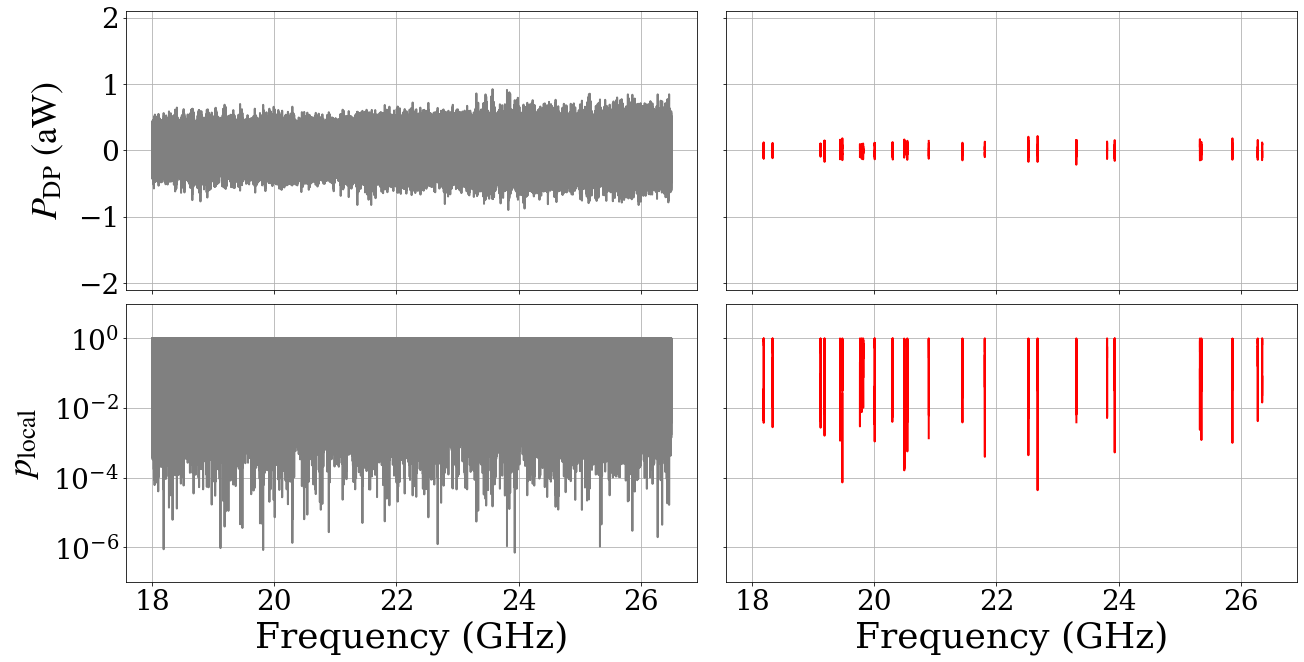

In [33]:
fig = plot_PDP_plocal_twocolumns(showAfter=True)
fig.savefig(f'{outdir}/plocal_twocolumns.png')

## Plot $P_{DP}$ & $p$-local data with histograms

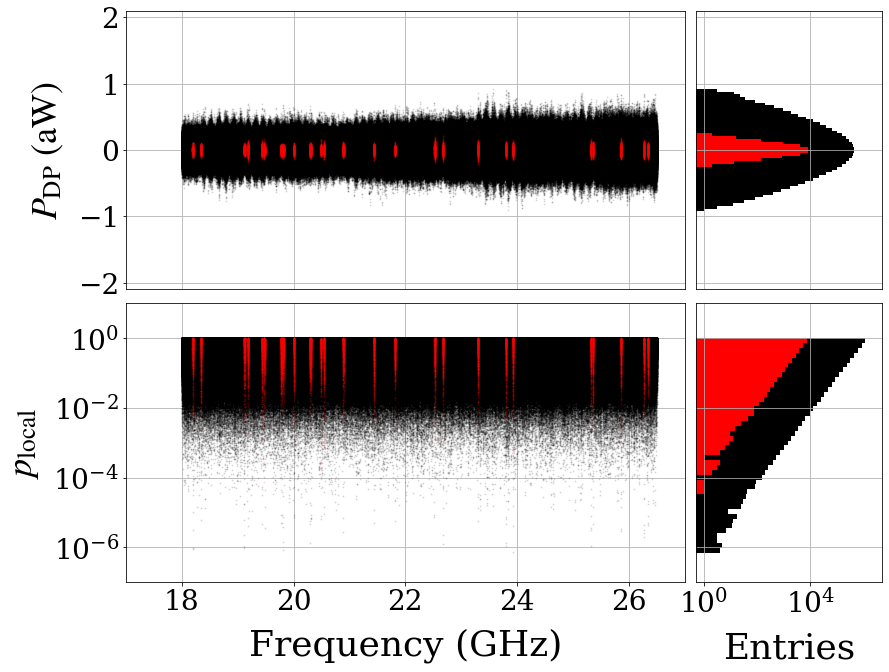

In [149]:
def plot_PDP_plocal2(showAfter=True, ismarker=True, markersize=2.0, alpha=0.3, markersize_add=None, alpha_add=None):
    fig, axes = plt.subplots(2,2,figsize=(14,10), squeeze=False, sharex=False, 
                            gridspec_kw={'width_ratios':[3,1], 'height_ratios': [1,1]})
    #before_color='black'
    #after_color='lightcoral'
    before_color='black'
    after_color='red'
    fig.tight_layout()

    # Frequency v.s. P or p-value
    if ismarker:
        axes[0][0].plot(freq_P_before.ravel()*1.0e-9, y_P_before.ravel()*W_conv, color=before_color, linestyle='', markersize=markersize, marker='o', alpha=alpha)
    else:
        axes[0][0].plot(freq_P_before.ravel()*1.0e-9, y_P_before.ravel()*W_conv, color=before_color, lw=2, alpha=alpha)
        pass
    if showAfter:
        for _f, _y in zip(freq_P_add, y_P_add):
            if ismarker:
                axes[0][0].plot(_f*1.0e-9, _y*W_conv, color=after_color, linestyle='', marker='o', 
                                markersize=markersize if markersize_add is None else markersize_add, 
                                alpha=alpha if alpha_add is None else alpha)
            else:
                axes[0][0].plot(_f*1.0e-9, _y*W_conv, color=after_color, lw=2,
                                alpha=alpha if alpha_add is None else alpha)
                pass
            pass
        pass
    if ismarker:
        axes[1][0].plot(freq_before.ravel()*1.0e-9, y_before.ravel(), color=before_color, linestyle='', marker='o', markersize=markersize, alpha=alpha)
    else:
        axes[1][0].plot(freq_before.ravel()*1.0e-9, y_before.ravel(), color=before_color, lw=2, alpha=alpha)
        pass
    if showAfter:
        for _f, _y in zip(freq_add, y_add):
            if ismarker:
                axes[1][0].plot(_f*1.0e-9, _y, color=after_color, linestyle='', marker='o',
                                markersize=markersize if markersize_add is None else markersize_add, 
                                alpha=alpha if alpha_add is None else alpha)
            else:
                axes[1][0].plot(_f*1.0e-9, _y, color=after_color, lw=2,
                                alpha=alpha if alpha_add is None else alpha)
                pass
            pass
        pass

    plt.rcParams["font.size"] = 28
    plt.rcParams["mathtext.fontset"] = 'stix'
    plt.rcParams["font.family"] = 'serif'

    xlim = [17., 27.]
    #ylim_P = [-0.18, 0.18]
    #ylim_P = [-1.1, 1.1]
    ylim_P = [-2.1, 2.1]
    yticks_P = [-2, -1, 0, 1, 2]
    #ylim_pvalue = [5e-7, 2]
    ylim_pvalue = [1e-7 , 1e+1]
    #yticks_pvalue = [1e-0, 1e-2, 1e-4, 1e-7]
    #yticks_pvalue = [1e+2, 1e-0, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10]
    yticks_pvalue = [1e-6, 1e-4, 1e-2, 1e-0]
    
    ax = axes[0][0]
    ax.grid()
    ax.set_ylabel(r"$P_{\rm DP} ~(\mathrm{aW})$", labelpad=12, fontsize=36)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim_P)
    ax.set_yticks(yticks_P)
    ax.tick_params(axis='x', bottom=False, top=False, labelbottom=False)
    ax = axes[1][0]
    ax.grid()
    ax.set_yscale("log")
    ax.set_ylabel(r"$p_{\rm local}$", labelpad=12, fontsize=36)
    ax.set_xlabel("Frequency (GHz)", fontsize=36, labelpad=12)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim_pvalue)
    ax.set_yticks(yticks_pvalue)
    
    fig.subplots_adjust(hspace=0.05, wspace=0.03, left=0.15, bottom=0.15, right=0.90)
    
    # Histograms of P or p-value
    bins_P = 100
    #bins_pvalue = bins_P
    nbins_pvalue = bins_P/2
    bins_pvalue = np.power( np.power(1./ylim_pvalue[0], 1/nbins_pvalue), np.arange(nbins_pvalue+1) ) * ylim_pvalue[0]
    xlog_hist = True
    xlim_hist = [0.5, 5e+6]
    xticks_hist = [1., 1e+4]
    grid_hist = 'both' # 'x' , 'y' or 'both'
    ax = axes[0][1]
    ax.hist(y_P_before.ravel()*W_conv, bins=bins_P, range=ylim_P, color=before_color, orientation='horizontal')
    ax.hist(y_P_add.ravel()*W_conv, bins=bins_P, range=ylim_P, color=after_color, orientation='horizontal')
    ax.grid(axis=grid_hist)
    if xlog_hist: ax.set_xscale('log')
    ax.set_xlim(xlim_hist)
    ax.set_xticks(xticks_hist)
    ax.set_ylim(ylim_P)
    ax.set_yticks(yticks_P)
    ax.tick_params(axis='x', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', left=False, right=False, labelleft=False)
    
    ax = axes[1][1]
    _hist, _bins, _tmp = ax.hist(y_before.ravel(), bins=bins_pvalue, color=before_color, orientation='horizontal')
    ax.hist(y_add.ravel(), bins=bins_pvalue, color=after_color, orientation='horizontal')
    ax.grid(axis=grid_hist)
    ax.set_yscale('log')
    if xlog_hist: ax.set_xscale('log')
    ax.set_xlim(xlim_hist)
    ax.set_xticks(xticks_hist)
    ax.set_ylim(ylim_pvalue)
    ax.set_yticks(yticks_pvalue)
    ax.tick_params(axis='y', left=False, right=False, labelleft=False)
    ax.set_xlabel("Entries", fontsize=36, labelpad=12)
    
    return fig

# referee suggested
fig2 = plot_PDP_plocal2(showAfter=True, ismarker=True, markersize=1.0, alpha=0.1, markersize_add=1.0, alpha_add=1.0)
# S. Adachi suggested
#fig2 = plot_PDP_plocal2(showAfter=True, ismarker=True, markersize=1.0, alpha=1.0, markersize_add=1.0, alpha_add=1.0)
#fig2 = plot_PDP_plocal2(showAfter=True, ismarker=True, markersize=2.0, alpha=1.0, markersize_add=1.0, alpha_add=1.0)

## Check $P_{DP}$

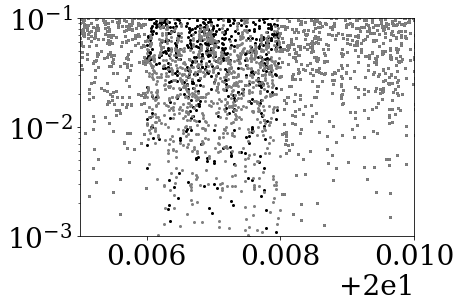

In [127]:
# Check for difference before & after zooming in 20GHz
diff_freq = freq_P_after
diff = y_P_after - y_P_before
#plt.plot(diff_freq*1.0e-9, diff)
plt.plot(diff_freq*1.0e-9, abs(y_P_before*W_conv), c='black', linestyle='', marker='o', markersize=2.0)
plt.plot(diff_freq*1.0e-9, abs(y_P_after*W_conv), c='gray', linestyle='', marker='o', markersize=2.0)
plt.xlim(20.005,20.01)
plt.ylim(1e-3,1e-1)
plt.yscale('log')

## Plot $P_{DP}$ only

In [ ]:
# Plot P_DP only
fig, axes = plt.subplots(1,1,figsize=(18,6), squeeze=False, sharex=True)
after_color='blue'
fig.tight_layout()
axes[0][0].plot(freq_P_before*1.0e-9, y_P_before*1e+19, color='blue', linewidth=1)
#axes[0][0].plot(freq_P_after*1.0e-9, y_P_after*1e+19, color=after_color, linewidth=1)

plt.rcParams["font.size"] = 28
plt.rcParams["mathtext.fontset"] = 'dejavusans'
plt.rcParams["font.family"] = 'dejavusans'

ax = axes[0][0]
ax.grid()
ax.set_ylim([-21, 21])
#ax.set_ylabel(r"$P_{\rm DP} ~[10^{-19}\mathrm{W}]$", labelpad=12, fontsize=36)
#ax.set_xlabel(r"Frequency $\nu$ [GHz]", labelpad=12, fontsize=36)

fig.subplots_adjust(hspace=0.05, left=0.15, bottom=0.15)
plt.show()
fig.savefig(f'{outdir}/pDP_onlybefore.png')

# Plot Powers

In [ ]:
# Not correctly implemented now
'''
for i in range(180, 265, 1):
    start_freq = i/10
    initial = int(start_freq * 1.e+6 - 250)
    final = int(initial + 1.e+5)

    for j in range(initial, final, 2000):
        word = list(str(j))
        word.insert(2, ".")
        start = "".join(word)
        
        for num in range(12):
            path = "/data/ms2840a/signal_raw_data/scan_FFT_{}GHz_span2.50MHz_rbw0.3kHz_2.0sec_1counts_12runs_{}.dat".format(start, num)
            freq W = func.dat_to_array(path)
            freq = data['freq']
            W = (data["W_0"]+data["W_1"]+data["W_2"]+data["W_3"]+data["W_4"]+data["W_5"]+data["W_6"]+data["W_7"]+data["W_8"]+data["W_9"]+data["W_10"]+data["W_11"])/12
            freq, W = func.cut_data(data["freq"], W)
            freq, W, Wstd = func.rebin_func(freq, W)
        
            with open("/data/ms2840a/result_data/real_data.csv", "a") as f:
                writer = csv.writer(f)
                for p in range(len(freq)):
                    writer.writerow([freq[p], W[p], Wstd[p]])
                    pass
                pass
            pass
        
        pass
    pass
'''

In [ ]:
plt.rcParams["font.size"] = 24
fig, axes = plt.subplots(2,1,figsize=(20,11), squeeze=False, sharex=True)

path = "/data/ms2840a/signal_raw_data/scan_FFT_19.999750GHz_span2.50MHz_rbw0.3kHz_2.0sec_1counts_12runs"
Watt = []
for i in range(12):
    Watt.append(func.dat_to_array(path + "_{}.dat".format(i))[1])
    freq = func.dat_to_array(path + "_{}.dat".format(i))[0]
    
W = np.zeros(0)
for i in range(len(Watt[0])):
    W = np.append(W, np.mean(np.array([Watt[j][i] for j in range(12)])))

ax = axes[0][0]
ax.plot((freq/1e9-20)*1e3, W*1e12, color="blue")
ax.grid()
ax.set_ylim([0,2])
#ax.set_yticks([-90,-85,-80])
ax.set_ylabel(r"$P_{\rm out}(\nu) ~[\times 10^{-12} ~\rm W]$")


#indir = "/data/ms2840a/result_data"
rebinfunc = -1 # No rebin
indir = '/data/analysis/dosue-k/output/result_data_newrebin2'
rebinfunc = 3 # newrebin2 case needs rebin here.

# 20 GHz
#init_freq = 20.
#path = f'{indir}/signal_12_data/start_18.999750GHz.csv'
# 18 GHz
init_freq = 18.
path = f'{indir}/signal_12_data/start_17.999750GHz.csv'

Watt = []
for i in range(12):
    Watt.append(func.csv_to_array(path)["W_{}".format(i)])
    freq = func.csv_to_array(path)["freq"]
diff_freq = np.diff(freq)
print(diff_freq)
    
W = np.zeros(0)
for i in range(len(Watt[0])):
    W = np.append(W, np.mean(np.array([Watt[j][i] for j in range(12)])))
    
# Rebinning to 2kHz bins: W (nominal data)
if   rebinfunc == 0: freq_rebin, W_rebin, W_rebin_err = func.rebin_func(freq, W)
elif rebinfunc == 1: freq_rebin, W_rebin, tmp = func.rebin_func_consider_rbw(freq, W, method=0)
elif rebinfunc == 2: freq_rebin, W_rebin = freq, W
elif rebinfunc == 3: freq_rebin, W_rebin, tmp = func.rebin_func_consider_rbw(freq, W, method=1)
else               : freq_rebin, W_rebin = freq, W
print(f'freq_rebin (size:{len(freq_rebin)} = {freq_rebin}')
print(f'W_rebin (size:{len(W_rebin)} = {W_rebin}')

ax = axes[1][0]
ax.plot((freq_rebin/1e9-init_freq)*1e3, W_rebin*1e19, color="blue")
ax.set_xlim([0.,2.])
ax.set_ylim([15.5,19.5])
#ax.set_ylim([16,20])
#ax.set_yticks([-160,-155,-150])
ax.set_ylabel(r"$P_{\rm in}(\nu) ~[\times 10^{-19} ~\rm W]$")
ax.set_xlabel(f"Frequency [MHz + {init_freq} GHz]")
ax.grid()

#plt.savefig("../result_figure/fit_result/raw_data.pdf")

In [ ]:
data1 = func.csv_to_array("/data/ms2840a/result_data/signal_raw_data.csv")
data2 = func.csv_to_array("/data/ms2840a/result_data/real_data.csv")

plt.rcParams["font.size"] = 24
fig, axes = plt.subplots(2,1,figsize=(20,11), squeeze=False, sharex=True)
#fig.suptitle("Result of Exp.1 ~ Exp.4")

ax = axes[0][0]

ax.plot(data1["freq"], np.log10(data1["W"]*1000)*10, color="blue")
ax.grid()
ax.set_ylabel(r"$P_{\rm out}(\nu)$ [dBm]")

ax = axes[1][0]

ax.plot(data2["freq"]/1e9, np.log10(data2["W_mean"]*1000)*10, color="blue")
ax.grid()
ax.set_ylabel(r"$P_{\rm measured}(\nu)$ [dBm]")
ax.set_xlabel("Frequency [GHz]")
                    
fig.tight_layout()

#plt.savefig("../result_figure/fit_result/raw_data.pdf")

In [ ]:
def p_glob(x):
    return 1-(1-x)**(4.25e6*0.38)

In [ ]:
x = np.array([1e-8])
while x[-1] < 0.1:
    xx = x[-1]*1.5
    x = np.append(x, xx)

plt.figure(figsize=(15,6))
plt.rcParams["font.size"] = 18
plt.plot(x, p_glob(x), color="blue")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$p_{\rm local}$")
plt.ylabel(r"$p_{\rm global}$")
plt.title(r"$p_{\rm global} = 1 - (1 - p_{\rm local})^{\mu N}$")
plt.grid()
#plt.savefig("../result_figure/N_eff/p_global.pdf")